In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import lightgbm as lgb
import xgboost as xgb
import torch
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
import pickle

In [2]:
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

In [63]:
df = pd.read_csv('./data/train.csv',engine='python')
test_df = pd.read_csv('./data/test.csv',engine='python')

In [64]:
def processing(dt):
    dt['Date(MM/DD/YYYY)']= pd.to_datetime(dt['Date(MM/DD/YYYY)'])
    dt = dt.assign(
        Month=  dt['Date(MM/DD/YYYY)'].dt.month,
        Day = dt['Date(MM/DD/YYYY)'].dt.day,
        Year =dt['Date(MM/DD/YYYY)'].dt.year,
                  )
    dt.drop('Date(MM/DD/YYYY)', axis=1, inplace=True)
    
    dt.loc[dt['Solar Radiance(w/m^2)']<0,'Solar Radiance(w/m^2)'] = 0
    mean_t, mean_s = dt.loc[(dt['Month']==2)&(dt['Temperature(C)']!=-99999.0 ),['Temperature(C)','Solar Power(kW)']].mean()
    dt.loc[dt['Temperature(C)']==-99999.0, ['Temperature(C)','Solar Power(kW)']] = (mean_t, mean_s)
    
    return dt

In [65]:
df = processing(df)
test_df = processing(test_df)

In [66]:
train_id = df.loc[df['Temperature(C)'].isnull()].index
id = test_df.loc[test_df['Temperature(C)'].isnull()].index

<AxesSubplot:>

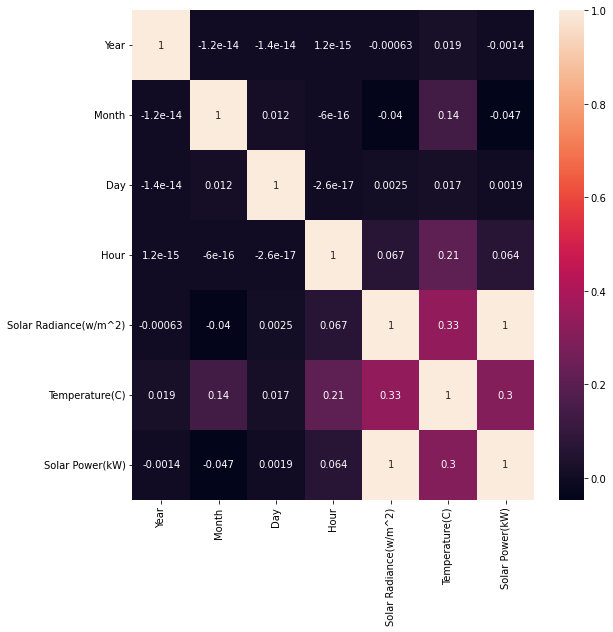

In [13]:
feature = ['Year','Month','Day','Hour','Solar Radiance(w/m^2)','Temperature(C)','Solar Power(kW)']
train_co = df[feature]
train_co
# print(train_co.corr())
train_co.corr()
plt.figure(figsize=(9,9))
sns.heatmap(train_co.corr(), annot=True)
# plt.figure(figsize=(9,9))
# sns.heatmap(test_df.corr(), annot=True)

In [67]:
train = df[:87600]
val = df[87600:96360]

In [17]:
features = ['Month','Day','Hour']
train_x = train[features]
train_y = train['Temperature(C)']

val_x = val[features]
val_y = val['Temperature(C)']

In [54]:
regr = RandomForestRegressor(n_estimators=2000, criterion='mse', random_state=28)
regr.fit(train_x,train_y)

RandomForestRegressor(n_estimators=2000, random_state=28)

In [56]:
from sklearn.metrics import mean_squared_error
mean_squared_error(random,train_y)

11.668182098194928

In [72]:
test = test_df.copy()

In [75]:
features = ['Month','Day','Hour']
test_x = test[features]
preds = regr.predict(test_x)

In [84]:
test.loc[id,'Temperature(C)'] = preds[id]

In [107]:
features = ['Hour','Temperature(C)']
train_x = train[features]
train_y = train['Solar Radiance(w/m^2)']

val_x = val[features]
val_y = val['Solar Radiance(w/m^2)']

In [108]:
dtrain = xgb.DMatrix(data=train_x, label = train_y)
dval = xgb.DMatrix(data=val_x, label = val_y)
wlist = [(dtrain, 'train'), (dval,'eval')]

params = {
    'learning_rate': 0.01,
    'objective': 'reg:squarederror',
    'metric':'mse', 
    'seed':42
}
 

model = xgb.train( params, dtrain, 1000, evals=wlist, verbose_eval=20, early_stopping_rounds=100)

[05:25:53] WARNING: ../src/learner.cc:576: 
Parameters: { "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:392.44357	eval-rmse:389.50571
[20]	train-rmse:326.60971	eval-rmse:325.20630
[40]	train-rmse:273.74753	eval-rmse:273.50345
[60]	train-rmse:231.67406	eval-rmse:232.42915
[80]	train-rmse:198.42950	eval-rmse:199.92520
[100]	train-rmse:172.50089	eval-rmse:174.49214
[120]	train-rmse:152.54404	eval-rmse:154.86002
[140]	train-rmse:137.51958	eval-rmse:139.96834
[160]	train-rmse:126.37869	eval-rmse:128.81937
[180]	train-rmse:118.25536	eval-rmse:120.61972
[200]	train-rmse:112.42262	eval-rmse:114.63487
[220]	train-rmse:108.28404	eval-rmse:110.29322
[240]	train-rmse:105.35941	eval-rmse:107.15256
[260]	train-rmse:103.32521	eval-rmse:1

KeyboardInterrupt: 

In [161]:
Pkl_Filename = "./model/Solar_Power_Model.pkl"  
Pkl_Filename2 = "./model/Solar_Radiance_Model.pkl"  
with open(Pkl_Filename, 'rb') as file:  
    Solar_Power_Model = pickle.load(file)
with open(Pkl_Filename2, 'rb') as file:  
    Solar_Radiance_Model = pickle.load(file)

In [164]:
features = ['Hour','Temperature(C)']
test_x = test[features]
test_x = xgb.DMatrix(test_x)

In [165]:
pred_power = Solar_Power_Model.predict(test_x)

In [166]:
test.loc[id,'Solar Power(kW)'] = pred_power[id]

In [169]:
test.loc[test['Solar Power(kW)']<0.1,'Solar Power(kW)'] = 0

In [170]:
features = ['Solar Power(kW)']
test_x = test[features]
test_x = xgb.DMatrix(test_x)
pre_radi = Solar_Radiance_Model.predict(test_x)

In [225]:
test.loc[id,'Solar Radiance(w/m^2)'] = pre_radi[id]

In [226]:
test.loc[test['Solar Radiance(w/m^2)']<0.1,'Solar Radiance(w/m^2)'] = 0

In [227]:
sample = pd.DataFrame(columns=['Month','Day','Hour','Solar Radiance(w/m^2)','Temperature(C)','Solar Power(kW)'])

In [228]:
sample = test.loc[id]
del sample['Year']

In [229]:
sample.reset_index(inplace=True)

In [230]:
del sample['ID']

In [231]:
sample.index.name = 'ID'

In [232]:
sample.to_csv('./result/rf+xg.csv')